# waypoints

## define agents

In [24]:
class FGAgent:
    def __init__(self, bubble_r=0.5, lookahead_degrees=[90., 270.], speed=2.0):
        self.bubble_r = bubble_r
        self.lookahead_degrees = lookahead_degrees
        self.speed = speed
        
    def get_action(self, state):
        ranges = state[:360]
        #print(ranges[10], ranges[90], ranges[180], ranges[270], ranges[350])
        beg = int(self.lookahead_degrees[0])
        end = int(self.lookahead_degrees[1])

        ranges = ranges[beg:end]

        ranges = np.clip(ranges, 0, 10.0)
        
        nearest_point = np.min(ranges)
        min_dist = nearest_point + self.bubble_r

        ranges = np.where(ranges <= min_dist, 0.0, ranges)

        gaps = []
        if ranges[0] != 0.0:
            gaps.append(0)

        i = 0
        while i < len(ranges):
            if ranges[i] == 0.0:
                if i > 0:
                    gaps.append(i-1)
                while i < len(ranges) and ranges[i] == 0.0:
                    i += 1
                if i < len(ranges):
                    gaps.append(i)
                continue

            i += 1

        if ranges[-1] != 0.0:
            gaps.append(len(ranges) - 1)

        assert len(gaps) % 2 == 0

        max_gap = -1
        gap_beg = 0
        gap_end = 360

        # find max gap
        i = 0
        while i < len(gaps):
            if gaps[i+1]-gaps[i] > max_gap:
                max_gap = gaps[i+1]-gaps[i]
                gap_beg = gaps[i]+beg
                gap_end = gaps[i+1]+beg
            i += 2

        mid_point = float(gap_end+gap_beg)/2.
        angle_deg = mid_point - 180
        angle_rad = angle_deg * (np.pi/180.)
#         print(f"midpoint:{mid_point}")
        angle = angle_rad * 1.0
        return [angle, self.speed]



In [40]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class WPEnv(gym.Env):
    
    def __init__(self, map_name='', begin_pos=None):
        self.map_name = map_name
        self.begin_pos = begin_pos
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"./f1tenth_gym/examples/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(render_callback)
        
        begin_pos = [0, 0, 0] if self.begin_pos is None else self.begin_pos
        obs, step_reward, done, info = self.env.reset(np.array([begin_pos]))
 
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, 10)
        buck = 3
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
                
        state = [
            agg_scanner,
            np.array(obs['linear_vels_x'][0]),
            np.array(obs['ang_vels_z'][0]),
            (obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0])
        ]

        return state
    
        
    def step(self, action):
        act = np.array([action])
        reward = 0
        obs, step_reward, done, info = self.env.step(act)
        
        if obs['collisions'][0] == 1.0:
            print("CRASHED")
            done = True
            reward = -1
        
                
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            print("DONE")
            done = True
        
        next_state = self.to_vector_state(obs)
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

WPEnv(map_name='SILVERSTONE')

## create waypoints

In [41]:

done = False
env = WPEnv(map_name='SILVERSTONE_TRAIN3', begin_pos=[0, 0, np.pi+1])
obs = env.reset()
agent = FGAgent(speed=3.0)

positions = []

while not done:
    positions.append(obs[3])
    th, v = agent.get_action(obs[0])
    obs, r, done, _ = env.step([th, v])
#     env.render()

DONE


In [42]:
with open('ss3-wp.np', 'wb') as f:
    np.save(f, positions)

## analyze waypoints

In [31]:
import numpy as np

with open('ss2-wp.np', 'rb') as f:
    wps = np.load(f)
    
dist = np.linalg.norm(wps[0][:2] - wps[52][:2])
print(dist)
print(len(wps))
print(len(wps)//300)

0.8745604745519705
15578
51


In [33]:
from tqdm import tqdm

map_name = 'SILVERSTONE_TRAIN2'
env = gym.make('f110_gym:f110-v0', map=f"./f1tenth_gym/examples/{map_name}", map_ext='.png', num_agents=1)

for wp in tqdm(wps):
    obs, step_reward, done, info = env.reset(
        np.array([
            wp
        ])
    )
    if min(obs['scans'][0]) < 0.5:
        print(min(obs['scans'][0]))
        

  3%|▎         | 441/15578 [00:00<00:06, 2220.17it/s]

0.4861406010136173
0.4861406010136173
0.4966346217096672
0.4946310243837726
0.4650440434137921
0.47571143985191683
0.4718700112162928


100%|██████████| 15578/15578 [00:06<00:00, 2299.68it/s]


In [44]:
from scipy.spatial.distance import cdist

x = cdist([[0,0]], wps[:,:2])
np.argmin(x)

0

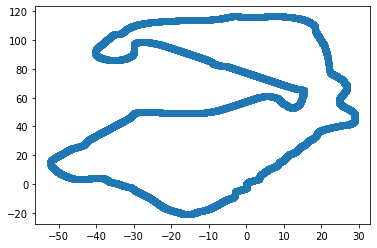

In [45]:
import matplotlib.pyplot as plt

plt.scatter(wps[:,0], wps[:, 1])

# environment

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=15.0,
                 n_cps = 200,
                 cp_reward = 0.1,
                 min_cp_dist=3.0,
                 train_map_name='SILVERSTONE_TRAIN',
                 safe_padding=0.3,
                 laps = 1.0
                ):
        
        self.laps = laps
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(222,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
    
    def _render_callback(self, env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800
  
    def load_train_setup(self):
        no = np.random.choice([1, 2, 3])
        
        map_path = f"./f1tenth_gym/examples/{self.train_map_name}{no}"
        with open(f'./ss{no}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"./f1tenth_gym/examples/{self.test_map_name}"
        with open('./ss-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
        self.cum_r = 0
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(self._render_callback)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
#         print(f"number of checkpoints: {len(self.checkpoints)}")
        
        if self.test_map_name is None:
            start_idx = np.random.randint(0, len(self.checkpoints))
            start_point = self.checkpoints[start_idx]
            
        else:
            dists = cdist([[0,0]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            start_point = [0., 0., np.pi+1]
            
        self.next_cp_idx = (start_idx + 2)%len(self.checkpoints)
            
        
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point
            ])
        )
        
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, self.scan_range)
        scanner = scanner[3*70:3*290]
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
#         if self.test_map_name is None:
#             noise = np.random.normal(loc=0.0, scale=0.03, size=state.shape)
#             state = state + noise
        
        return state
    
    def checkpoint(self, position):
        return_cp_idx = (self.next_cp_idx - 10)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        
        
        th = action[1]*np.pi/6
        act = np.array([[th, act_v]])

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        next_state = self.to_vector_state(obs)
        position = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            if self.test_map_name is not None:
                print('CRASHED')
            return next_state, reward, done, {}
            
        cp_reward = self.checkpoint(position)
        reward += cp_reward
        self.t += 1
        
        if obs['lap_counts'][0] == self.laps:
            t = obs['lap_times'][0]  
#             reward = np.exp(2.5 - 0.05*t)
            fairlap = 50
            reward = max(0.2*(fairlap - t), self.cp_reward)
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            done = True
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.max(self.prev_vel)<3.0:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
        if np.min(obs['scans'][0]) < self.safe_padding:
            reward += -0.05
            self.total_padding_punish -= 0.05
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset()

array([0.21360768, 0.22079288, 0.2213891 , 0.22040109, 0.22078523,
       0.22228827, 0.22108942, 0.22173245, 0.22852529, 0.22477448,
       0.22581514, 0.22571482, 0.22427417, 0.22875706, 0.23629479,
       0.22743049, 0.23217237, 0.23227781, 0.23819115, 0.23885518,
       0.2458116 , 0.24481759, 0.24579029, 0.24382787, 0.25076685,
       0.25351863, 0.25176679, 0.25567515, 0.25483727, 0.26279346,
       0.26371326, 0.27014857, 0.26770506, 0.26703216, 0.27615799,
       0.28379067, 0.28830103, 0.29614828, 0.29508762, 0.30126192,
       0.30896566, 0.3205908 , 0.33220108, 0.33236378, 0.33640353,
       0.33979534, 0.35221506, 0.37028119, 0.38965994, 0.40509943,
       0.45994635, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

# training

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()



# with half cheeta configs

hc_configs = {
    'framework': 'torch',
    'num_workers': 15,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
#     'model': {
#         'fcnet_hiddens': [512, 512],
#     },
    'num_envs_per_worker': 1,
    'train_batch_size': 100000,
    'sgd_minibatch_size': 4096,
    'batch_mode': 'truncate_episodes',
    'lr': .0003,
}


trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
# print("FINE TUNING")
# trainer.restore('./checkpoints/v1.9/checkpoint_000116/checkpoint-116')

print(trainer.config)
rewards = []
best_reward = -100

import pickle

for i in range(300):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open('./checkpoints/v2.1_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0 and episode_r > best_reward:
        best_reward = episode_r
        cp = trainer.save("./checkpoints/v2.1")
        print("checkpoint saved at", cp)


2022-04-11 18:56:48,778	WARNING ppo.py:223 -- `train_batch_size` (100000) cannot be achieved with your other settings (num_workers=15 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 6666.
2022-04-11 18:56:48,779	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-11 18:56:48,779	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=17634) 2022-04-11 18:56:56,702	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=17650) 2022-04-11 18:56:56,712	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVecto

{'num_workers': 15, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 6666, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0003, 'train_batch_size': 100000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [256, 256], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_

2022-04-11 18:58:07,407	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:-0.8925784966698382
checkpoint saved at ./checkpoints/v2.1/checkpoint_000001/checkpoint-1
episode: 1 reward:-0.8699267782426778
episode: 2 reward:-0.6894451962110961
episode: 3 reward:-0.44025735294117646
episode: 4 reward:-0.027002583979328035
episode: 5 reward:0.6498113207547171
checkpoint saved at ./checkpoints/v2.1/checkpoint_000006/checkpoint-6
episode: 6 reward:1.6563953488372085
episode: 7 reward:2.2418238993710675
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 66.96999999999736. Finish reward: 0.1. Padding punish: -0.1
episode: 8 reward:3.351652892561978
episode: 9 reward:4.099047619047613
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.350000000000023 in 65.73999999999673. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.000000000000007 in 65.57999999999664. Finish reward: 

(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 60.21999999999659. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 59.28999999999677. Finish reward: 0.1. Padding punish: 0
episode: 15 reward:8.639999999999997
checkpoint saved at ./checkpoints/v2.1/checkpoint_000016/checkpoint-16
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 60.11999999999661. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.350000000000023 in 58.89999999999685. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 58.149999999997. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/

(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 57.73999999999708. Finish reward: 0.1. Padding punish: -0.1
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.34999999999716. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 56.98999999999723. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 59.48999999999673. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.27999999999717. Finish reward: 0.1. Padding punish: 0
episode: 20 reward:10.216499999999998
checkpoint saved at ./checkpoints/v2.1/checkpoint_000021/checkpoint-21
(RolloutWorker pid=17648) agent on ./f1tenth_gym/example

(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.350000000000023 in 56.37999999999735. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 57.269999999997175. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 56.53999999999732. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.100000000000016 in 56.08999999999741. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 55.84999999999746. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.00000000000001 in 57.39999999999715. Finish reward: 0.1. Padding pun

(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 53.649999999997895. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 54.1399999999978. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 7.649999999999989 in 53.909999999997844. Finish reward: 0.1. Padding punish: -0.8500000000000002
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 53.77999999999787. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.100000000000012 in 53.86999999999785. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 2.9000000000000012 in 10.269999999999825. RETURNED
(Rollout

(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 54.52999999999772. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.05000000000002 in 54.059999999997814. Finish reward: 0.1. Padding punish: -0.35
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.600000000000005 in 54.249999999997776. Finish reward: 0.1. Padding punish: -0.7000000000000001
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.850000000000012 in 54.79999999999767. Finish reward: 0.1. Padding punish: -0.25
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.900000000000013 in 54.099999999997806. Finish reward: 0.1. Padding punish: -0.2
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 54.349999999997756. Finish

(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.050000000000015 in 53.93999999999784. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 54.259999999997774. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.050000000000015 in 54.099999999997806. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.70000000000001 in 52.749999999998074. Finish reward: 0.1. Padding punish: -0.7000000000000001
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 53.22999999999798. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 53.20999999999798. Finish

(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 52.93999999999804. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.5 in 53.82999999999786. Finish reward: 0.1. Padding punish: -0.49999999999999994
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 53.26999999999797. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 53.08999999999801. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 53.57999999999791. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 53.78999999999787. Finish reward: 0.1. Padding punish

(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 13.699999999999958 in 52.88999999999805. Finish reward: 0.1. Padding punish: -0.6
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 52.089999999998206. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.750000000000014 in 52.36999999999815. Finish reward: 0.1. Padding punish: -0.5499999999999999
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.05000000000002 in 52.97999999999803. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 18.599999999999994 in 53.099999999998005. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.60000000000001 in 52.88999999999805. Finish re

episode: 34 reward:11.085000000000004
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.200000000000014 in 52.35999999999815. Finish reward: 0.1. Padding punish: -0.2
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 52.35999999999815. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 52.6299999999981. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 17.749999999999982 in 52.32999999999816. Finish reward: 0.1. Padding punish: -0.8500000000000002
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.050000000000015 in 52.16999999999819. Finish reward: 0.1. Padding punish: -0.35
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 18.4499999999999

(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 8.799999999999985 in 51.77999999999827. Finish reward: 0.1. Padding punish: -0.49999999999999994
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.14999999999839. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 50.339999999998554. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 17.199999999999974 in 50.25999999999857. Finish reward: 0.1. Padding punish: -0.1
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.30999999999836. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.950000000000014 in 51.21999999999838. Finish reward: 0.

(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 49.94999999999863. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.100000000000012 in 49.45999999999873. Finish reward: 0.10800000000025421. Padding punish: -0.3
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.049999999999986 in 49.29999999999876. Finish reward: 0.14000000000024784. Padding punish: -1.0500000000000003
episode: 38 reward:11.55058000000001
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 49.30999999999876. Finish reward: 0.13800000000024823. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 16.799999999999965 in 49.0999999999988. Finish reward: 0.18000000000023988. Padding punish: -0.6
(RolloutWorker pid=17634) agent on ./f1tent

(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.52999999999911. Finish reward: 0.4940000000001774. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.35999999999915. Finish reward: 0.5280000000001707. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.850000000000005 in 47.769999999999065. Finish reward: 0.44600000000018697. Padding punish: -0.5499999999999999
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.95000000000001 in 47.77999999999906. Finish reward: 0.44400000000018736. Padding punish: -0.35
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 18.85 in 48.779999999998864. Finish reward: 0.24400000000022715. Padding punish: -1.2500000000000004
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SIL

(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.15000000000002 in 47.47999999999912. Finish reward: 0.5040000000001754. Padding punish: -0.15000000000000002
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 14.999999999999963 in 47.97999999999902. Finish reward: 0.4040000000001953. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.67999999999928. Finish reward: 0.6640000000001436. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.500000000000007 in 48.43999999999893. Finish reward: 0.31200000000021366. Padding punish: -0.6
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 9.299999999999983 in 47.419999999999135. Finish reward: 0.5160000000001731. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE

(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 46.669999999999284. Finish reward: 0.6660000000001433. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.900000000000006 in 47.5899999999991. Finish reward: 0.48200000000017984. Padding punish: -0.49999999999999994
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 47.93999999999903. Finish reward: 0.41200000000019377. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.0999999999992. Finish reward: 0.5800000000001603. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.35 in 48.68999999999888. Finish reward: 0.26200000000022355. Padding punish: -0.7500000000000001
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERST

(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.250000000000018 in 48.19999999999898. Finish reward: 0.3600000000002041. Padding punish: -0.05
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.25999999999917. Finish reward: 0.5480000000001667. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.78999999999926. Finish reward: 0.642000000000148. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 46.709999999999276. Finish reward: 0.6580000000001448. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.359999999999346. Finish reward: 0.7280000000001309. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 

(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.83999999999925. Finish reward: 0.63200000000015. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.63999999999929. Finish reward: 0.672000000000142. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 45.17999999999958. Finish reward: 0.9640000000000839. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 9.449999999999976 in 24.100000000000968. RETURNED
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.369999999999344. Finish reward: 0.7260000000001313. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.55000000000001 in 46.11999999999939. Finish rewar

(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.259999999999366. Finish reward: 0.7480000000001269. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.25000000000002 in 46.02999999999941. Finish reward: 0.7940000000001177. Padding punish: -0.15000000000000002
episode: 49 reward:11.043700000000047
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 46.969999999999224. Finish reward: 0.6060000000001552. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 46.27999999999936. Finish reward: 0.7440000000001277. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 45.309999999999555. Finish reward: 0.9380000000000891. Padding punish: 0
(RolloutWorker pid=17656) agent on

(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.200000000000017 in 45.51999999999951. Finish reward: 0.8960000000000975. Padding punish: -0.2
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 45.61999999999949. Finish reward: 0.8760000000001015. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 45.93999999999943. Finish reward: 0.8120000000001142. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.28999999999936. Finish reward: 0.7420000000001281. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 46.42999999999933. Finish reward: 0.7140000000001336. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 2

(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 46.01999999999941. Finish reward: 0.7960000000001174. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 45.909999999999435. Finish reward: 0.818000000000113. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.84999999999925. Finish reward: 0.6300000000001504. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 45.53999999999951. Finish reward: 0.8920000000000983. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 46.37999999999934. Finish reward: 0.7240000000001316. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.1000

(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 45.049999999999606. Finish reward: 0.9900000000000788. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.000000000000018 in 47.05999999999921. Finish reward: 0.5880000000001587. Padding punish: -0.3
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.650000000000006 in 45.19999999999958. Finish reward: 0.9600000000000848. Padding punish: -0.65
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 44.359999999999744. Finish reward: 1.1280000000000514. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 45.17999999999958. Finish reward: 0.9640000000000839. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got rew

(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 43.85999999999984. Finish reward: 1.2280000000000315. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.100000000000016 in 45.0699999999996. Finish reward: 0.9860000000000796. Padding punish: -0.2
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.35 in 44.98999999999962. Finish reward: 1.0020000000000764. Padding punish: -1.0500000000000003
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 4.6 in 13.759999999999751. RETURNED
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 44.36999999999974. Finish reward: 1.1260000000000516. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 44.03999999999981. Finish reward: 

(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 44.66999999999968. Finish reward: 1.0660000000000636. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 43.61999999999989. Finish reward: 1.276000000000022. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.00000000000001 in 44.42999999999973. Finish reward: 1.114000000000054. Padding punish: -0.39999999999999997
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.000000000000014 in 43.51999999999991. Finish reward: 1.296000000000018. Padding punish: -0.39999999999999997
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.350000000000012 in 43.52999999999991. Finish reward: 1.2940000000000182. Padding punish: -1.0500000000000003
(RolloutWorker pid=17650) agent on ./f1t

episode: 62 reward:9.971840000000013
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 1.3 in 44.909999999999634. Finish reward: 1.0180000000000733. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 44.21999999999977. Finish reward: 1.1560000000000457. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.4 in 44.849999999999646. Finish reward: 1.0300000000000709. Padding punish: -0.7000000000000001
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.90000000000001 in 43.599999999999895. Finish reward: 1.2800000000000211. Padding punish: -0.39999999999999997
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 43.42999999999993. Finish reward: 1.3140000000000143. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_

(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 45.47999999999952. Finish reward: 0.9040000000000958. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.70000000000001 in 43.43999999999993. Finish reward: 1.3120000000000147. Padding punish: -0.7000000000000001
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.150000000000002 in 44.13999999999979. Finish reward: 1.1720000000000426. Padding punish: -1.1500000000000004
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 43.71999999999987. Finish reward: 1.256000000000026. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 18.799999999999997 in 44.20999999999977. Finish reward: 1.1580000000000454. Padding punish: -1.3000000000000005
(RolloutWorker pid=17641) agent on ./f1

(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 4.6 in 12.559999999999777. RETURNED
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.740000000000066. Finish reward: 1.4519999999999869. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 9.099999999999984 in 20.700000000000436. RETURNED
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.900000000000013 in 44.649999999999686. Finish reward: 1.070000000000063. Padding punish: -0.49999999999999994
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.890000000000036. Finish reward: 1.4219999999999928. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 43.70999999999987. Finish reward: 1.2580000000000255. Padding p

(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.13000000000019. Finish reward: 1.5739999999999625. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 43.11999999999999. Finish reward: 1.376000000000002. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 42.96000000000002. Finish reward: 1.4079999999999957. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 43.91999999999983. Finish reward: 1.216000000000034. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.0500000000002. Finish reward: 1.5899999999999594. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.650000

(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.35 in 43.60999999999989. Finish reward: 1.2780000000000216. Padding punish: -0.7500000000000001
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.53000000000011. Finish reward: 1.4939999999999785. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 43.23999999999997. Finish reward: 1.3520000000000068. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 15.49999999999996 in 34.910000000001624. RETURNED
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 43.08. Finish reward: 1.3840000000000003. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 43.52999999999991. Finish reward: 1

(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.600000000000094. Finish reward: 1.4799999999999813. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.42000000000013. Finish reward: 1.5159999999999743. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.18000000000018. Finish reward: 1.5639999999999645. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.750000000000014 in 42.62000000000009. Finish reward: 1.4759999999999822. Padding punish: -0.65
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 6.249999999999994 in 16.399999999999764. RETURNED
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.840000000000245. Fin

(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.900000000000013 in 42.290000000000155. Finish reward: 1.541999999999969. Padding punish: -0.2
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.95000000000022. Finish reward: 1.6099999999999555. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.70000000000027. Finish reward: 1.6599999999999455. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.40000000000033. Finish reward: 1.7199999999999336. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.050000000000015 in 41.53000000000031. Finish reward: 1.6939999999999387. Padding punish: -0.25
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got rewar

(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.350000000000023 in 41.93000000000023. Finish reward: 1.6139999999999546. Padding punish: -0.05
episode: 74 reward:10.822459999999987
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 42.0600000000002. Finish reward: 1.5879999999999599. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.36000000000034. Finish reward: 1.727999999999932. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.0 in 42.31000000000015. Finish reward: 1.5379999999999698. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.900000000000016 in 43.199999999999974. Finish reward: 1.3600000000000052. Padding punish: -0.2
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILV

(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.80000000000001 in 42.32000000000015. Finish reward: 1.5359999999999703. Padding punish: -0.3
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 7.39999999999999 in 41.78000000000026. Finish reward: 1.6439999999999486. Padding punish: -0.2
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 7.19999999999999 in 17.13999999999988. RETURNED
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.46000000000032. Finish reward: 1.707999999999936. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.10000000000002 in 41.77000000000026. Finish reward: 1.6459999999999484. Padding punish: -0.2
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 9.299999999999983 in 21.020000000000486. RETU

(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.72000000000027. Finish reward: 1.6559999999999464. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.490000000000116. Finish reward: 1.501999999999977. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.43000000000013. Finish reward: 1.5139999999999745. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.900000000000013 in 42.650000000000084. Finish reward: 1.4699999999999833. Padding punish: -0.2
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 6.099999999999994 in 16.69999999999981. RETURNED
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 4.899999999999999 in 13.999999999999746. RETUR

(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 41.47000000000032. Finish reward: 1.7059999999999365. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.490000000000116. Finish reward: 1.501999999999977. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.43000000000013. Finish reward: 1.5139999999999745. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.300000000000008 in 43.03000000000001. Finish reward: 1.3939999999999984. Padding punish: -0.8000000000000002
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 41.940000000000225. Finish reward: 1.611999999999955. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN

(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.17000000000038. Finish reward: 1.7659999999999245. Padding punish: 0
episode: 81 reward:10.506399999999987
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 42.5700000000001. Finish reward: 1.4859999999999802. Padding punish: -0.05
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.5800000000003. Finish reward: 1.6839999999999407. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.150000000000016 in 42.750000000000064. Finish reward: 1.4499999999999873. Padding punish: -0.15000000000000002
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.290000000000354. Finish reward: 1.7419999999999292. Padding punish: 0
(RolloutWorker pid=17638) agent o

(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.96000000000022. Finish reward: 1.607999999999956. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.95000000000042. Finish reward: 1.8099999999999157. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.900000000000013 in 41.25000000000036. Finish reward: 1.7499999999999276. Padding punish: -0.49999999999999994
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.73000000000027. Finish reward: 1.6539999999999466. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 5.299999999999997 in 13.609999999999754. RETURNED
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.300000000000022 in 41.850000

episode: 84 reward:11.374359999999985
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 41.62000000000029. Finish reward: 1.6759999999999424. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.88000000000024. Finish reward: 1.6239999999999526. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.43000000000033. Finish reward: 1.7139999999999347. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.98000000000022. Finish reward: 1.6039999999999566. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.91000000000023. Finish reward: 1.617999999999954. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/

(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 14.599999999999964 in 34.250000000001755. RETURNED
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 41.33000000000035. Finish reward: 1.7339999999999307. Padding punish: -0.1
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.000000000000014 in 42.5600000000001. RETURNED
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.140000000000384. Finish reward: 1.7719999999999232. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.5700000000003. Finish reward: 1.6859999999999404. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.290000000000155. Finish reward: 1.541999999999969. Padding punish:

(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.05000000000002 in 43.41999999999993. Finish reward: 1.316000000000014. Padding punish: -0.25
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.800000000000054. Finish reward: 1.4399999999999893. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.150000000000016 in 42.67000000000008. Finish reward: 1.4659999999999842. Padding punish: -0.15000000000000002
episode: 87 reward:12.005679999999986
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.70000000000027. Finish reward: 1.6599999999999455. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 41.27000000000036. Finish reward: 1.7459999999999285. Padding punish: 0
(RolloutWorker pid=17656) agent o

(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.840000000000444. Finish reward: 1.8319999999999113. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.500000000000007 in 42.0600000000002. Finish reward: 1.5879999999999599. Padding punish: -0.8000000000000002
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.690000000000275. Finish reward: 1.661999999999945. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.390000000000335. Finish reward: 1.7219999999999331. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 6.349999999999994 in 17.819999999999986. RETURNED
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.55000000000001 in 42.790000

(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.24000000000056. Finish reward: 1.9519999999998874. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 42.0500000000002. Finish reward: 1.5899999999999594. Padding punish: -0.1
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.850000000000012 in 42.140000000000185. Finish reward: 1.571999999999963. Padding punish: -0.25
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.31000000000035. Finish reward: 1.73799999999993. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 4.6 in 41.5600000000003. Finish reward: 1.68799999999994. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 i

(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.850000000000016 in 42.42000000000013. Finish reward: 1.5159999999999743. Padding punish: -0.44999999999999996
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 43.10999999999999. Finish reward: 1.3780000000000017. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.890000000000235. Finish reward: 1.621999999999953. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.87000000000024. Finish reward: 1.6259999999999524. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.46000000000012. Finish reward: 1.5079999999999758. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAI

(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.150000000000002 in 42.61000000000009. Finish reward: 1.4779999999999818. Padding punish: -0.9500000000000003
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 43.050000000000004. Finish reward: 1.3899999999999992. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.850000000000016 in 41.75000000000026. Finish reward: 1.6499999999999475. Padding punish: -0.25
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.540000000000106. Finish reward: 1.491999999999979. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.13000000000019. Finish reward: 1.5739999999999625. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_

(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.700000000000003 in 42.690000000000076. Finish reward: 1.4619999999999849. Padding punish: -0.39999999999999997
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.950000000000014 in 42.140000000000185. Finish reward: 1.571999999999963. Padding punish: -0.15000000000000002
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 42.32000000000015. Finish reward: 1.5359999999999703. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.200000000000006 in 43.20999999999997. Finish reward: 1.3580000000000056. Padding punish: -1.1000000000000003
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.400000000000006 in 42.5700000000001. Finish reward: 1.4859999999999802. Padding punish: -0.7000000000000001
(RolloutWorker p

(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 42.25000000000016. Finish reward: 1.5499999999999674. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.190000000000175. Finish reward: 1.561999999999965. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 18.699999999999974 in 43.45999999999992. Finish reward: 1.3080000000000156. Padding punish: -1.6000000000000008
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.53000000000011. Finish reward: 1.4939999999999785. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 43.000000000000014. Finish reward: 1.3999999999999972. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN

(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 6.699999999999992 in 42.71000000000007. Finish reward: 1.4579999999999858. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.80000000000001 in 43.02000000000001. Finish reward: 1.3959999999999981. Padding punish: -0.3
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.750000000000014 in 44.249999999999766. Finish reward: 1.150000000000047. Padding punish: -0.35
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.900000000000016 in 42.5600000000001. Finish reward: 1.4879999999999798. Padding punish: -0.49999999999999994
episode: 98 reward:11.270119999999995
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 9.799999999999981 in 42.61000000000009. Finish reward: 1.4779999999999818. Padding punish: 0
(RolloutWorker pid=17636) agen

(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 43.599999999999895. Finish reward: 1.2800000000000211. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.21000000000017. Finish reward: 1.5579999999999659. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.750000000000014 in 41.61000000000029. Finish reward: 1.677999999999942. Padding punish: -0.35
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 42.76000000000006. Finish reward: 1.4479999999999877. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 15.499999999999961 in 35.450000000001516. RETURNED
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.5800000000001. Fin

(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 41.70000000000027. Finish reward: 1.6599999999999455. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.96000000000022. Finish reward: 1.607999999999956. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.31000000000035. Finish reward: 1.73799999999993. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.7 in 42.0600000000002. Finish reward: 1.5879999999999599. Padding punish: -0.7000000000000001
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.85000000000024. Finish reward: 1.6299999999999515. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40

(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.040000000000205. Finish reward: 1.591999999999959. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.65000000000001 in 41.91000000000023. Finish reward: 1.617999999999954. Padding punish: -0.44999999999999996
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 42.82000000000005. Finish reward: 1.4359999999999902. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.37000000000014. Finish reward: 1.5259999999999723. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.100000000000012 in 43.5699999999999. Finish reward: 1.28600000000002. Padding punish: -0.2
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN

(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.73000000000027. Finish reward: 1.6539999999999466. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 41.72000000000027. Finish reward: 1.6559999999999464. Padding punish: -0.05
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 15.199999999999962 in 34.5400000000017. RETURNED
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.85000000000024. Finish reward: 1.6299999999999515. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 42.390000000000136. Finish reward: 1.521999999999973. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.540000000000305. Finis

(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 6.199999999999994 in 41.97000000000022. Finish reward: 1.6059999999999564. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.740000000000265. Finish reward: 1.651999999999947. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 10.19999999999998 in 42.5700000000001. Finish reward: 1.4859999999999802. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.750000000000014 in 42.440000000000126. Finish reward: 1.511999999999975. Padding punish: -0.35
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward -1.3000000000000005 in 41.040000000000404. RETURNED
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.5600000000003. Finis

(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.82000000000045. Finish reward: 1.8359999999999106. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.130000000000386. Finish reward: 1.7739999999999227. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 40.5500000000005. Finish reward: 1.8899999999998998. Padding punish: -0.1
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.22000000000037. Finish reward: 1.7559999999999265. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.25000000000036. Finish reward: 1.7499999999999276. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.4

(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.91000000000043. Finish reward: 1.8179999999999141. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.00000000000041. Finish reward: 1.7999999999999177. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.96000000000042. Finish reward: 1.8079999999999161. Padding punish: 0
episode: 108 reward:12.022299999999975
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 41.490000000000315. Finish reward: 1.7019999999999371. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.50000000000001 in 42.0600000000002. Finish reward: 1.5879999999999599. Padding punish: -0.6
(RolloutWorker pid=17648) agent on ./f1tenth_gym/exa

(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.840000000000444. Finish reward: 1.8319999999999113. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 4.3500000000000005 in 41.840000000000245. Finish reward: 1.631999999999951. Padding punish: -0.5499999999999999
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 41.78000000000026. Finish reward: 1.6439999999999486. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.030000000000406. Finish reward: 1.7939999999999188. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.390000000000335. Finish reward: 1.7219999999999331. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRA

(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 41.20000000000037. Finish reward: 1.7599999999999256. Padding punish: -0.15000000000000002
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.590000000000295. Finish reward: 1.681999999999941. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.090000000000394. Finish reward: 1.7819999999999212. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 0.5 in 41.77000000000026. RETURNED
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.880000000000436. Finish reward: 1.8239999999999128. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.090000000000394. Fi

(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 14.499999999999964 in 41.51000000000031. Finish reward: 1.697999999999938. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.31000000000035. Finish reward: 1.73799999999993. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.130000000000386. Finish reward: 1.7739999999999227. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.780000000000456. Finish reward: 1.8439999999999088. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.950000000000014 in 42.51000000000011. Finish reward: 1.4979999999999778. Padding punish: -0.15000000000000002
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN

(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.900000000000013 in 42.0500000000002. Finish reward: 1.5899999999999594. Padding punish: -0.2
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.990000000000414. Finish reward: 1.8019999999999172. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 42.5800000000001. Finish reward: 1.4839999999999804. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.000000000000007 in 42.0800000000002. Finish reward: 1.5839999999999606. Padding punish: -0.39999999999999997
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 4.000000000000002 in 41.5800000000003. Finish reward: 1.6839999999999407. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAI

episode: 115 reward:13.52019999999998
checkpoint saved at ./checkpoints/v2.1/checkpoint_000116/checkpoint-116
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 42.840000000000046. Finish reward: 1.4319999999999908. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.0800000000002. Finish reward: 1.5839999999999606. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.51000000000031. Finish reward: 1.697999999999938. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 42.650000000000084. Finish reward: 1.4699999999999833. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 42.950000000000024. Finish reward: 1.4099999999999953.

(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 41.16000000000038. Finish reward: 1.767999999999924. Padding punish: -0.15000000000000002
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 5.399999999999997 in 42.340000000000146. Finish reward: 1.531999999999971. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 43.17999999999998. Finish reward: 1.3640000000000043. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.00000000000021. Finish reward: 1.5999999999999575. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 18.9 in 41.60000000000029. Finish reward: 1.6799999999999415. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 1

(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 42.32000000000015. Finish reward: 1.5359999999999703. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 42.10000000000019. Finish reward: 1.5799999999999614. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.100000000000016 in 42.86000000000004. Finish reward: 1.4279999999999917. Padding punish: -0.2
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.78000000000026. Finish reward: 1.6439999999999486. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 42.0500000000002. Finish reward: 1.5899999999999594. Padding punish: -0.1
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 

(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.950000000000017 in 42.21000000000017. Finish reward: 1.5579999999999659. Padding punish: -0.15000000000000002
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.62000000000029. Finish reward: 1.6759999999999424. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.5600000000003. Finish reward: 1.68799999999994. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.91000000000023. Finish reward: 1.617999999999954. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.80000000000001 in 42.16000000000018. Finish reward: 1.5679999999999639. Padding punish: -0.3
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1

(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 0.25000000000000006 in 40.71000000000047. RETURNED
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.090000000000394. Finish reward: 1.7819999999999212. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.590000000000295. Finish reward: 1.681999999999941. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.05000000000002 in 43.46999999999992. Finish reward: 1.306000000000016. Padding punish: -0.25
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 41.88000000000024. Finish reward: 1.6239999999999526. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.36000000000034. Finis

(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 41.71000000000027. Finish reward: 1.657999999999946. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.600000000000012 in 42.390000000000136. Finish reward: 1.521999999999973. Padding punish: -0.49999999999999994
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.950000000000017 in 42.890000000000036. Finish reward: 1.4219999999999928. Padding punish: -0.44999999999999996
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 8.249999999999986 in 20.34000000000038. RETURNED
episode: 122 reward:12.896439999999986
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.950000000000014 in 43.70999999999987. Finish reward: 1.2580000000000255. Padding punish: -0.35
(RolloutWorker pid=17638) agent on ./f1tenth_gym/exampl

(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 41.83000000000025. Finish reward: 1.6339999999999506. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 41.140000000000384. Finish reward: 1.7719999999999232. Padding punish: -0.15000000000000002
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.5500000000005. Finish reward: 1.8899999999998998. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.950000000000017 in 41.70000000000027. Finish reward: 1.6599999999999455. Padding punish: -0.15000000000000002
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 16.649999999999967 in 41.90000000000023. Finish reward: 1.6199999999999535. Padding punish: -0.7500000000000001
(RolloutWorker pid=17651) agent on 

(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.050000000000015 in 40.81000000000045. Finish reward: 1.8379999999999102. Padding punish: -0.35
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.630000000000486. Finish reward: 1.8739999999999029. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.900000000000013 in 41.31000000000035. Finish reward: 1.73799999999993. Padding punish: -0.2
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.45000000000001 in 41.82000000000025. Finish reward: 1.6359999999999504. Padding punish: -0.65
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.950000000000014 in 41.690000000000275. Finish reward: 1.661999999999945. Padding punish: -0.15000000000000002
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVE

(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.85000000000044. Finish reward: 1.8299999999999117. Padding punish: 0
episode: 126 reward:11.80753999999997
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 42.02000000000021. Finish reward: 1.5959999999999583. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.950000000000014 in 42.13000000000019. Finish reward: 1.5739999999999625. Padding punish: -0.15000000000000002
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.740000000000464. Finish reward: 1.8519999999999073. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.730000000000466. Finish reward: 1.8539999999999068. Padding punish: 0
(RolloutWorker pid=17632) agent on

(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.24000000000056. Finish reward: 1.9519999999998874. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.05000000000002 in 41.12000000000039. Finish reward: 1.7759999999999225. Padding punish: -0.05
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 4.699999999999999 in 12.129999999999786. RETURNED
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 40.81000000000045. Finish reward: 1.8379999999999102. Padding punish: -0.15000000000000002
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.050000000000015 in 40.70000000000047. Finish reward: 1.8599999999999057. Padding punish: -0.05
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in

(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.97000000000062. Finish reward: 2.0059999999998768. Padding punish: 0
episode: 129 reward:11.579939999999965
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.09000000000059. Finish reward: 1.9819999999998814. Padding punish: 0
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.650000000000006 in 41.78000000000026. Finish reward: 1.6439999999999486. Padding punish: -0.44999999999999996
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 9.799999999999978 in 40.95000000000042. Finish reward: 1.8099999999999157. Padding punish: -0.2
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.930000000000625. Finish reward: 2.013999999999875. Padding punish: 0
(RolloutWorker pid=17650) agent o

(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 6.349999999999993 in 40.5700000000005. Finish reward: 1.8859999999999006. Padding punish: -0.15000000000000002
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 40.81000000000045. Finish reward: 1.8379999999999102. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.32000000000055. Finish reward: 1.9359999999998907. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.94000000000062. Finish reward: 2.0119999999998757. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 41.02000000000041. Finish reward: 1.7959999999999186. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN

(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.000000000000014 in 41.0700000000004. Finish reward: 1.7859999999999205. Padding punish: -0.1
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.75000000000066. Finish reward: 2.049999999999868. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.680000000000675. Finish reward: 2.063999999999865. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.330000000000744. Finish reward: 2.133999999999851. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 40.81000000000045. Finish reward: 1.8379999999999102. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.4

(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.74000000000066. Finish reward: 2.0519999999998677. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 18.19999999999999 in 39.72000000000067. RETURNED
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.84000000000064. Finish reward: 2.0319999999998717. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.69000000000067. Finish reward: 2.0619999999998657. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.270000000000756. Finish reward: 2.145999999999849. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 9.99999999999998 in 22.240000000000677. RETURNED
(R

(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.76000000000066. Finish reward: 2.047999999999868. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.150000000000006 in 40.51000000000051. Finish reward: 1.8979999999998982. Padding punish: -0.9500000000000003
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 38.90000000000083. Finish reward: 2.219999999999834. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.220000000000766. Finish reward: 2.155999999999847. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 15.099999999999957 in 33.42000000000192. RETURNED
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 39.760000000

(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.31000000000055. Finish reward: 1.9379999999998903. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.080000000000595. Finish reward: 1.983999999999881. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.45000000000052. Finish reward: 1.9099999999998958. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 41.46000000000032. Finish reward: 1.707999999999936. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.09000000000059. Finish reward: 1.9819999999998814. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.8500

(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 18.799999999999997 in 40.24000000000056. Finish reward: 1.9519999999998874. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 41.0500000000004. Finish reward: 1.7899999999999197. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.850000000000016 in 40.24000000000056. Finish reward: 1.9519999999998874. Padding punish: -0.25
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.59000000000069. Finish reward: 2.0819999999998617. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.11000000000059. Finish reward: 1.9779999999998823. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 1

(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 40.780000000000456. Finish reward: 1.8439999999999088. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.62000000000069. Finish reward: 2.075999999999863. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 1.9000000000000006 in 6.669999999999902. RETURNED
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.780000000000655. Finish reward: 2.043999999999869. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.46000000000052. Finish reward: 1.9079999999998962. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 11.699999999999974 in 25.950000000001257. RETURNE

(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.90000000000001 in 41.20000000000037. Finish reward: 1.7599999999999256. Padding punish: -0.2
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 4.799999999999999 in 40.540000000000504. Finish reward: 1.8919999999998993. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.19000000000077. Finish reward: 2.161999999999846. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.480000000000715. Finish reward: 2.103999999999857. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 20.00000000000001 in 40.680000000000476. Finish reward: 1.8639999999999048. Padding punish: -0.3
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 

(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.26000000000056. Finish reward: 1.9479999999998883. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.330000000000744. Finish reward: 2.133999999999851. Padding punish: 0
episode: 143 reward:10.312019999999963
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.60000000000001 in 40.42000000000053. RETURNED
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 8.599999999999985 in 18.29000000000006. RETURNED
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.900000000000016 in 39.92000000000063. Finish reward: 2.015999999999875. Padding punish: -0.2
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.450000000000003 in 41.240000000000364. Finish rewa

(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.27000000000056. Finish reward: 1.9459999999998887. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.100000000000012 in 39.95000000000062. Finish reward: 2.009999999999876. Padding punish: -0.3
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.99000000000061. Finish reward: 2.0019999999998777. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 10.299999999999983 in 25.060000000001118. RETURNED
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 15.749999999999954 in 34.910000000001624. RETURNED
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.26000000000076. Finish reward: 2.1479999999998483. Padding punis

(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.05000000000002 in 41.21000000000037. Finish reward: 1.757999999999926. Padding punish: -0.05
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.29000000000055. Finish reward: 1.9419999999998894. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 8.899999999999984 in 19.100000000000186. RETURNED
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.50000000000051. Finish reward: 1.8999999999998978. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 18.900000000000002 in 41.52000000000031. Finish reward: 1.6959999999999384. Padding punish: -1.4000000000000006
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.05000000000002 in 40.1100

(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 16.599999999999966 in 42.00000000000021. Finish reward: 1.5999999999999575. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 10.599999999999978 in 22.13000000000066. RETURNED
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 39.72000000000067. Finish reward: 2.055999999999867. Padding punish: -0.15000000000000002
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.130000000000585. Finish reward: 1.973999999999883. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.62000000000069. Finish reward: 2.075999999999863. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 4.4 in 40.880000000000436. Fini

(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.6 in 41.27000000000036. Finish reward: 1.7459999999999285. Padding punish: -0.49999999999999994
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.25000000000056. Finish reward: 1.9499999999998878. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.050000000000015 in 40.70000000000047. Finish reward: 1.8599999999999057. Padding punish: -0.35
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.15000000000002 in 39.680000000000675. Finish reward: 2.063999999999865. Padding punish: -0.25
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.950000000000014 in 41.32000000000035. Finish reward: 1.7359999999999305. Padding punish: -0.15000000000000002
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SI

(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.90000000000063. Finish reward: 2.019999999999874. Padding punish: 0
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.59000000000069. Finish reward: 2.0819999999998617. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.02000000000061. Finish reward: 1.9959999999998788. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 42.5600000000001. Finish reward: 1.4879999999999798. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.15000000000002 in 40.97000000000042. Finish reward: 1.8059999999999166. Padding punish: -0.25
episode: 151 reward:10.839359999999974
(RolloutWorker pid=17648) agent on ./f1tenth_gym/exam

(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 40.580000000000496. Finish reward: 1.8839999999999009. Padding punish: -0.1
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.900000000000013 in 41.76000000000026. Finish reward: 1.647999999999948. Padding punish: -0.39999999999999997
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 11.099999999999977 in 24.730000000001066. RETURNED
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 41.02000000000041. Finish reward: 1.7959999999999186. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.700000000000014 in 40.20000000000057. Finish reward: 1.9599999999998858. Padding punish: -0.7000000000000001
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.400

(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.70000000000001 in 41.96000000000022. Finish reward: 1.607999999999956. Padding punish: -0.39999999999999997
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 16.19999999999996 in 42.27000000000016. Finish reward: 1.5459999999999683. Padding punish: -0.39999999999999997
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.850000000000005 in 40.92000000000043. Finish reward: 1.8159999999999146. Padding punish: -0.5499999999999999
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.72000000000067. Finish reward: 2.055999999999867. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.99000000000061. Finish reward: 2.0019999999998777. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1t

(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.050000000000015 in 42.0800000000002. Finish reward: 1.5839999999999606. Padding punish: -0.05
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 17.449999999999978 in 40.87000000000044. Finish reward: 1.8259999999999126. Padding punish: -0.15000000000000002
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.71000000000067. Finish reward: 2.057999999999866. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.50000000000051. Finish reward: 1.8999999999998978. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.950000000000017 in 40.47000000000052. Finish reward: 1.9059999999998967. Padding punish: -0.15000000000000002
(RolloutWorker pid=17641) agent on ./f1tenth_gym/exa

(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.71000000000067. Finish reward: 2.057999999999866. Padding punish: 0
episode: 157 reward:10.168639999999971
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.35000000000001 in 40.96000000000042. Finish reward: 1.8079999999999161. Padding punish: -0.7500000000000001
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 40.32000000000055. Finish reward: 1.9359999999998907. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 11.099999999999962 in 25.750000000001226. RETURNED
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 17.099999999999973 in 36.09000000000139. RETURNED
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 7.999999999999988 in 41.52000000000

(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.080000000000595. Finish reward: 1.983999999999881. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.92000000000063. Finish reward: 2.015999999999875. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 39.630000000000685. Finish reward: 2.073999999999863. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 41.92000000000023. Finish reward: 1.6159999999999544. Padding punish: 0
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.60000000000001 in 41.0700000000004. Finish reward: 1.7859999999999205. Padding punish: -0.39999999999999997
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1

(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 39.880000000000635. Finish reward: 2.023999999999873. Padding punish: -0.05
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 5.699999999999996 in 13.749999999999751. RETURNED
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.31000000000055. Finish reward: 1.9379999999998903. Padding punish: 0
episode: 160 reward:11.085099999999962
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 40.690000000000474. Finish reward: 1.8619999999999053. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 41.71000000000027. Finish reward: 1.657999999999946. Padding punish: 0
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 6.199

(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 0.8999999999999996 in 5.549999999999926. RETURNED
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.10000000000002 in 39.5400000000007. Finish reward: 2.0919999999998597. Padding punish: -0.3
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.22000000000057. Finish reward: 1.9559999999998867. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.000000000000014 in 40.67000000000048. Finish reward: 1.8659999999999046. Padding punish: -0.1
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.399999999999995 in 41.490000000000315. Finish reward: 1.7019999999999371. Padding punish: -0.7000000000000001
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 9.24999999999998 in 21.0

(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.490000000000514. Finish reward: 1.9019999999998973. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 4.550000000000001 in 12.789999999999772. RETURNED
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.41000000000073. Finish reward: 2.117999999999854. Padding punish: 0
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.90000000000001 in 41.0600000000004. Finish reward: 1.78799999999992. Padding punish: -0.2
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.700000000000014 in 40.46000000000052. Finish reward: 1.9079999999998962. Padding punish: -0.7000000000000001
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.950000000000017 in 40.400000

(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 39.630000000000685. Finish reward: 2.073999999999863. Padding punish: -0.15000000000000002
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 39.26000000000076. Finish reward: 2.1479999999998483. Padding punish: -0.05
(RolloutWorker pid=17638) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.850000000000005 in 40.16000000000058. Finish reward: 1.9679999999998843. Padding punish: -0.5499999999999999
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 19.65000000000001 in 41.030000000000406. Finish reward: 1.7939999999999188. Padding punish: -0.35
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.67000000000068. Finish reward: 2.065999999999865. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym

(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 6.949999999999991 in 16.599999999999795. RETURNED
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 40.45000000000052. Finish reward: 1.9099999999998958. Padding punish: 0
(RolloutWorker pid=17642) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.100000000000012 in 39.59000000000069. Finish reward: 2.0819999999998617. Padding punish: -0.3
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.780000000000655. Finish reward: 2.043999999999869. Padding punish: 0
(RolloutWorker pid=17650) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.19000000000077. Finish reward: 2.161999999999846. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 38.580000000000894. Finis

(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.52000000000071. Finish reward: 2.095999999999859. Padding punish: 0
(RolloutWorker pid=17651) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.380000000000734. Finish reward: 2.123999999999853. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 12.499999999999964 in 28.20000000000161. RETURNED
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.050000000000015 in 41.31000000000035. Finish reward: 1.73799999999993. Padding punish: -0.05
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.14000000000078. Finish reward: 2.171999999999844. Padding punish: 0
(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.350000000000005 in 39.370000000000736. RETURNE

(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 38.96000000000082. Finish reward: 2.2079999999998363. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.15000000000002 in 39.60000000000069. Finish reward: 2.079999999999862. Padding punish: -0.25
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.74000000000066. Finish reward: 2.0519999999998677. Padding punish: 0
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 20.000000000000014 in 40.880000000000436. Finish reward: 1.8239999999999128. Padding punish: -0.1
(RolloutWorker pid=17632) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 17.049999999999972 in 35.77000000000145. RETURNED
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 6.499999999999993 in 15.159999999999721. R

(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.67000000000068. Finish reward: 2.065999999999865. Padding punish: 0
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.5600000000007. Finish reward: 2.08799999999986. Padding punish: 0
(RolloutWorker pid=17648) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 12.74999999999996 in 30.13000000000191. RETURNED
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.200000000000014 in 39.51000000000071. Finish reward: 2.097999999999858. Padding punish: -0.2
(RolloutWorker pid=17654) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 11.549999999999972 in 40.39000000000053. Finish reward: 1.9219999999998933. Padding punish: -0.15000000000000002
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 1.9000000000000006 in 6.93999999

(RolloutWorker pid=17655) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.87000000000064. Finish reward: 2.025999999999873. Padding punish: 0
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 19.450000000000006 in 39.50000000000071. Finish reward: 2.099999999999858. Padding punish: -0.15000000000000002
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN3 got reward 2.1000000000000005 in 6.259999999999911. RETURNED
(RolloutWorker pid=17623) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.020000000000806. Finish reward: 2.195999999999839. Padding punish: 0
(RolloutWorker pid=17656) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.76000000000066. Finish reward: 2.047999999999868. Padding punish: 0
episode: 172 reward:10.391719999999964
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got r

(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.05000000000001 in 39.94000000000062. Finish reward: 2.0119999999998757. Padding punish: -0.35
(RolloutWorker pid=17634) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 39.49000000000071. Finish reward: 2.1019999999998578. Padding punish: 0
(RolloutWorker pid=17640) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 19.900000000000013 in 39.65000000000068. Finish reward: 2.069999999999864. Padding punish: -0.49999999999999994
(RolloutWorker pid=17636) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 7.499999999999989 in 18.010000000000016. RETURNED
(RolloutWorker pid=17658) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN2 got reward 6.999999999999991 in 16.079999999999714. RETURNED
(RolloutWorker pid=17641) agent on ./f1tenth_gym/examples/SILVERSTONE_TRAIN1 got reward 20.200000000000017 in 40.42000000000053. Finish reward: 1.915999999999

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [1]:
#!rm -rf checkpoints/v2.0

## evaluation

In [11]:
import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
# DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/v2.1/checkpoint_000031/checkpoint-31')



2022-04-12 16:32:09,484	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-04-12 16:32:09,491	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ./checkpoints/v2.1/checkpoint_000031/checkpoint-31
2022-04-12 16:32:09,492	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 31, '_timesteps_total': 6199380, '_time_total': 1487.5876996517181, '_episodes_total': 5846}


In [15]:
done = False
env = F110RaceEnv({}, test_map_name='SILVERSTONE_OBS', laps=1)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

CRASHED
reward:4.649999999999996


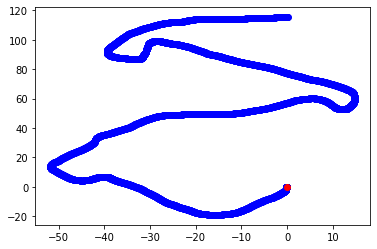

In [8]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])
plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')

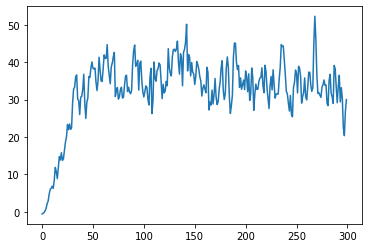

In [44]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/race_v1.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

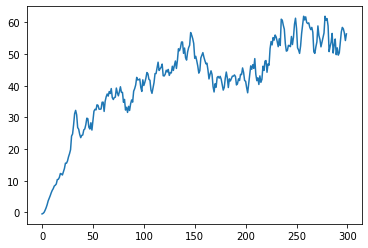

In [4]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/v1.2_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

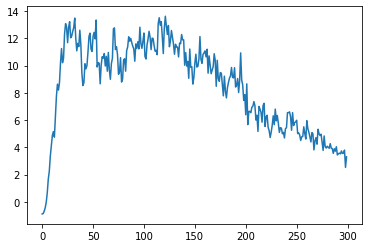

In [4]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/v2.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
